## Preprocessing & Exploratory Data Analysis (Nonspatial EDA)

In [2]:
#Import Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import contextily as ctx
import geopandas as gpd
import libpysal as ps 
from esda import Moran, Moran_Local
from splot.esda import moran_scatterplot, lisa_cluster
from shapely.geometry import Point, polygon, box
import rasterio
import raster4ml
import requests
import openmeteo_requests
import requests_cache
from retry_requests import retry
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from mgwr.gwr import GWR,MGWR
from mgwr.sel_bw import Sel_BW

In [ ]:
eia_plant_inventory = pd.read_csv("/home/shalini/projects/academic-research/uiuc/tx-datacenters-geospatial-analysis/data/processed/eia_plant_inventory.csv")
plant_fuel_mix= pd.read_csv("/home/shalini/projects/academic-research/uiuc/tx-datacenters-geospatial-analysis/data/processed/plant_fuel_mix.csv")

### II. Data Cleaning and Preprocessing

Combine Forms EIA-860M: Monthly Inventory of Operable Electric Generators, and EIA-923: Electric Power Operations (Annual and Monthly) into one dataset. 
<br>Retrieve coordinates from EIA-860 API pull, merge with monthly fuel mix report by electricity generator from EIA-923, and convert latitude and longitude columns into geometry column for spatial analysis.

In [16]:
eia_data = pd.merge(plant_fuel_mix, 
                    eia_plant_inventory[['plantid', 'plantName', 'balancing-authority-name', 'entityid','entityName', 'county', 'latitude', 'longitude', 'nameplate-capacity-mw', 'net-summer-capacity-mw', 'net-winter-capacity-mw']], 
                    left_on=['plantCode', 'plantName'], right_on=['plantid', 'plantName'], 
                    how='left', suffixes=('_fuel', '_inventory'))
eia_data = eia_data.merge(counties, on='county', how='left')
eia_data_gdf = gpd.GeoDataFrame(eia_data, geometry=gpd.points_from_xy(eia_data['longitude'], eia_data['latitude']), crs='EPSG:4326')

In [17]:
eia_data_gdf.head()

,period,plantCode,plantName,fuel2002,fuelTypeDescription,state,stateDescription,primeMover,average-heat-content,average-heat-content-units,...,entityName,county,latitude,longitude,nameplate-capacity-mw,net-summer-capacity-mw,net-winter-capacity-mw,Solar Region,Wind Region,geometry
0,2022-07,9,Copper,ALL,Total,TX,Texas,ALL,0.000,None,...,El Paso Electric Co,El Paso,31.7569,-106.375,3215.3,2331.0,2405.0,FarWest,West,POINT (-106.375 31.7569)
1,2022-07,9,Copper,DFO,Distillate Fuel Oil,TX,Texas,ALL,0.000,MMBtu per barrels,...,El Paso Electric Co,El Paso,31.7569,-106.375,3215.3,2331.0,2405.0,FarWest,West,POINT (-106.375 31.7569)
2,2022-07,9,Copper,DFO,Distillate Fuel Oil,TX,Texas,GT,0.000,MMBtu per barrels,...,El Paso Electric Co,El Paso,31.7569,-106.375,3215.3,2331.0,2405.0,FarWest,West,POINT (-106.375 31.7569)
3,2022-07,9,Copper,NG,Natural Gas,TX,Texas,ALL,1.022,MMBtu per Mcf,...,El Paso Electric Co,El Paso,31.7569,-106.375,3215.3,2331.0,2405.0,FarWest,West,POINT (-106.375 31.7569)
4,2022-07,9,Copper,NG,Natural Gas,TX,Texas,GT,1.022,MMBtu per Mcf,...,El Paso Electric Co,El Paso,31.7569,-106.375,3215.3,2331.0,2405.0,FarWest,West,POINT (-106.375 31.7569)


In [19]:
# Add County Polygons to counties df for spatial analysis
counties_gdf = tx_counties.merge(counties, left_on='NAME', right_on='county', how='left')
counties_gdf = counties_gdf[['county', 'Solar Region', 'Wind Region', 'geometry']]

#### Create Tidy Monthly Electricity Generation Table (Totals and Percentages by Fuel Type) Using Aggregation Methods and Pivot Operations

In [20]:
drop_cols = ['average-heat-content-units', 'consumption-for-eg-btu-units', 'generation-units', 'latitude', 'longitude']  # unit columns to drop from eia_data
monthly_plant_gen = eia_data_gdf.drop(columns=drop_cols)
monthly_plant_gen = monthly_plant_gen[(monthly_plant_gen['fuelTypeDescription'] != 'Total') & (~monthly_plant_gen['fuel2002'].isin(['MWH', 'PUR']))]  # Exclude electricity purchased by power plants from other providers

In [ ]:
monthly_plant_gen.to_csv("/home/shalini/projects/academic-research/uiuc/tx-datacenters-geospatial-analysis/data/processed/monthly_plant_gen.csv")

In [22]:
plant_info_cols = ['period', 'plantid', 'plantName', 'balancing-authority-name', 'entityid', 'entityName', 'county', 'geometry', 'Solar Region', 'Wind Region', 'nameplate-capacity-mw','net-summer-capacity-mw', 'net-winter-capacity-mw']

# Total absolute generation by fuel type (MWh)
total_monthly_egen_by_fueltype = monthly_plant_gen.pivot_table(
    index=plant_info_cols,
    columns='fuelTypeDescription',
    values='generation',
    aggfunc='sum',
    fill_value=0).reset_index()

# Add suffix to fuel type generation columns
total_monthly_egen_by_fueltype.rename(columns={col: f"{col}_gen_total" for col in total_monthly_egen_by_fueltype.columns if col not in plant_info_cols}, inplace=True)

fuel_cols = [col for col in total_monthly_egen_by_fueltype.columns if col not in plant_info_cols]

# Compute total generation across fuels grouped by plant_info_cols
total_monthly_egen_by_fueltype['total_generation'] = total_monthly_egen_by_fueltype[fuel_cols].sum(axis=1)

# Drop total_generation column if value is all 0 or NA
if total_monthly_egen_by_fueltype['total_generation'].isna().all() or (total_monthly_egen_by_fueltype['total_generation'] == 0).all():
    total_monthly_egen_by_fueltype.drop(columns='total_generation', inplace=True)
else:
    # Add percentage columns for each fuel type in 'fuelTypeDescription'
    for col in fuel_cols:
        base_name = col.replace('_gen_total', '')  # remove '_gen_total' to avoid suffix duplication on new pct cols
        total_monthly_egen_by_fueltype[f'{base_name}_gen_pct'] = (total_monthly_egen_by_fueltype[col] / total_monthly_egen_by_fueltype['total_generation']) * 100

total_monthly_egen_by_fueltype.sort_values(by='Natural Gas_gen_pct', ascending= False).head(25)

fuelTypeDescription,period,plantid,plantName,balancing-authority-name,entityid,entityName,county,geometry,Solar Region,Wind Region,...,Nuclear_gen_pct,Other_gen_pct,Other Gases_gen_pct,Petroleum Coke_gen_pct,Residual Fuel Oil_gen_pct,Solar_gen_pct,Waste Oil and Other Oils_gen_pct,Wind_gen_pct,Wood Waste Solids_gen_pct,other renewables_gen_pct
12094,2023-12,4195,Powerlane Plant,"Electric Reliability Council of Texas, Inc.",7634,City of Greenville - (TX),Hunt,POINT (-96.1264 33.1707),FarEast,North,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5616,2023-03,4195,Powerlane Plant,"Electric Reliability Council of Texas, Inc.",7634,City of Greenville - (TX),Hunt,POINT (-96.1264 33.1707),FarEast,North,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15069,2024-04,3482,Jones,Southwest Power Pool,17718,Southwestern Public Service Co,Lubbock,POINT (-101.7392 33.5239),NorthWest,Panhandle,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11836,2023-11,64777,WAL456,"Electric Reliability Council of Texas, Inc.",64315,"Walmart Stores Texas, LLC",Cameron,POINT (-97.51944 25.97606),SouthEast,Coastal,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11837,2023-11,64778,WAL461,"Electric Reliability Council of Texas, Inc.",64315,"Walmart Stores Texas, LLC",Maverick,POINT (-100.48272 28.70203),SouthEast,South,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11838,2023-11,64791,WAL462,"Electric Reliability Council of Texas, Inc.",64315,"Walmart Stores Texas, LLC",Brazoria,POINT (-95.23078 29.42176),FarEast,Coastal,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11839,2023-11,64792,WAL504,"Electric Reliability Council of Texas, Inc.",64315,"Walmart Stores Texas, LLC",Galveston,POINT (-94.83294 29.26514),FarEast,Coastal,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11840,2023-11,64793,WAL522,"Electric Reliability Council of Texas, Inc.",64315,"Walmart Stores Texas, LLC",Harris,POINT (-95.06497 29.89446),FarEast,South,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11841,2023-11,64794,WAL529,"Electric Reliability Council of Texas, Inc.",64315,"Walmart Stores Texas, LLC",Galveston,POINT (-95.00045 29.3723),FarEast,Coastal,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11842,2023-11,64795,WAL536,"Electric Reliability Council of Texas, Inc.",64315,"Walmart Stores Texas, LLC",Jones,POINT (-99.69802 32.48078),CenterWest,West,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Aggregate Hourly Weather Data for Each Data Center

In [24]:
datacenter_agg_weather = weather_gdf.groupby('datacenter').agg({
    'wet_bulb_temperature_2m': ['mean', 'max', 'std'],
    'temperature_2m': ['mean', 'max'],
    'precipitation': ['mean','sum'],
    'relative_humidity_2m': 'mean',
    'geometry': 'first'}).reset_index()
datacenter_agg_weather.columns = ['_'.join(col).strip('_') for col in datacenter_agg_weather.columns]
datacenter_agg_weather = datacenter_agg_weather.rename(columns={'geometry_first': 'geometry'})

In [25]:
datacenter_agg_weather = datacenters_counties.merge(datacenter_agg_weather, on=('datacenter'), how='inner')

#### Aggregate Total Monthly Electricity Generation by Fuel Type Data Across Counties, Solar Regions, and Wind Regions

In [26]:
#list cols in total_monthly_egen_by_fueltype
print(total_monthly_egen_by_fueltype.columns.tolist())

['period', 'plantid', 'plantName', 'balancing-authority-name', 'entityid', 'entityName', 'county', 'geometry', 'Solar Region', 'Wind Region', 'nameplate-capacity-mw', 'net-summer-capacity-mw', 'net-winter-capacity-mw', 'Coal_gen_total', 'Distillate Fuel Oil_gen_total', 'Hydroelectric Conventional_gen_total', 'Municiapl Landfill Gas_gen_total', 'Natural Gas_gen_total', 'Nuclear_gen_total', 'Other_gen_total', 'Other Gases_gen_total', 'Petroleum Coke_gen_total', 'Residual Fuel Oil_gen_total', 'Solar_gen_total', 'Waste Oil and Other Oils_gen_total', 'Wind_gen_total', 'Wood Waste Solids_gen_total', 'other renewables_gen_total', 'total_generation', 'Coal_gen_pct', 'Distillate Fuel Oil_gen_pct', 'Hydroelectric Conventional_gen_pct', 'Municiapl Landfill Gas_gen_pct', 'Natural Gas_gen_pct', 'Nuclear_gen_pct', 'Other_gen_pct', 'Other Gases_gen_pct', 'Petroleum Coke_gen_pct', 'Residual Fuel Oil_gen_pct', 'Solar_gen_pct', 'Waste Oil and Other Oils_gen_pct', 'Wind_gen_pct', 'Wood Waste Solids_gen_p

In [27]:
monthly_agg_county_fuel_mix = total_monthly_egen_by_fueltype.groupby(['county', 'period']).agg({
    # For generation totals, sum across all months/plants
    'Coal_gen_total': 'sum',
    'Distillate Fuel Oil_gen_total': 'sum',
    'Hydroelectric Conventional_gen_total': 'sum',
    'Municiapl Landfill Gas_gen_total': 'sum',
    'Natural Gas_gen_total': 'sum',
    'Nuclear_gen_total': 'sum',
    'Other_gen_total': 'sum',
    'Other Gases_gen_total': 'sum',
    'Petroleum Coke_gen_total': 'sum',
    'Residual Fuel Oil_gen_total': 'sum',
    'Solar_gen_total': 'sum',
    'Waste Oil and Other Oils_gen_total': 'sum',
    'Wind_gen_total': 'sum',
    'Wood Waste Solids_gen_total': 'sum',
    'other renewables_gen_total': 'sum',
    'total_generation': 'sum',
    
    # For percentages, take the mean (since they're already percentages)
    'Coal_gen_pct': 'mean',
    'Distillate Fuel Oil_gen_pct': 'mean',
    'Hydroelectric Conventional_gen_pct': 'mean',
    'Municiapl Landfill Gas_gen_pct': 'mean',
    'Natural Gas_gen_pct': 'mean',
    'Nuclear_gen_pct': 'mean',
    'Other_gen_pct': 'mean',
    'Other Gases_gen_pct': 'mean',
    'Petroleum Coke_gen_pct': 'mean',
    'Residual Fuel Oil_gen_pct': 'mean',
    'Solar_gen_pct': 'mean',
    'Waste Oil and Other Oils_gen_pct': 'mean',
    'Wind_gen_pct': 'mean',
    'Wood Waste Solids_gen_pct': 'mean',
    'other renewables_gen_pct': 'mean',
    
    # Keep first value for regions (should be same within county)
    'Solar Region': 'first',
    'Wind Region': 'first',
    
    # Keep plant capacity info (sum across all plants in county)
    'nameplate-capacity-mw': 'sum',
    'net-summer-capacity-mw': 'sum',
    'net-winter-capacity-mw': 'sum'
}).reset_index()


In [28]:
monthly_agg_county_fuel_mix = counties_gdf.merge(monthly_agg_county_fuel_mix, on=['county', 'Solar Region', 'Wind Region'], how='left')
monthly_agg_county_fuel_mix.head()

,county,Solar Region,Wind Region,geometry,period,Coal_gen_total,Distillate Fuel Oil_gen_total,Hydroelectric Conventional_gen_total,Municiapl Landfill Gas_gen_total,Natural Gas_gen_total,...,Petroleum Coke_gen_pct,Residual Fuel Oil_gen_pct,Solar_gen_pct,Waste Oil and Other Oils_gen_pct,Wind_gen_pct,Wood Waste Solids_gen_pct,other renewables_gen_pct,nameplate-capacity-mw,net-summer-capacity-mw,net-winter-capacity-mw
0,Ochiltree,NorthWest,Panhandle,"POLYGON ((-100.93606 36.4996, -100.91851 36.49...",2022-07,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,100.0,0.0,0.0,9311.1,9311.1,9311.1
1,Ochiltree,NorthWest,Panhandle,"POLYGON ((-100.93606 36.4996, -100.91851 36.49...",2022-08,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,100.0,0.0,0.0,9311.1,9311.1,9311.1
2,Ochiltree,NorthWest,Panhandle,"POLYGON ((-100.93606 36.4996, -100.91851 36.49...",2022-09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,100.0,0.0,0.0,9311.1,9311.1,9311.1
3,Ochiltree,NorthWest,Panhandle,"POLYGON ((-100.93606 36.4996, -100.91851 36.49...",2022-10,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,100.0,0.0,0.0,9311.1,9311.1,9311.1
4,Ochiltree,NorthWest,Panhandle,"POLYGON ((-100.93606 36.4996, -100.91851 36.49...",2022-11,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,100.0,0.0,0.0,9311.1,9311.1,9311.1


(array([90., 19., 11.,  2., 12.,  3.,  0.,  4.,  2.,  2.,  0.,  2.,  1.,
         2.,  5.,  0.,  0.,  0.,  0.,  2.]),
 array([7.5000000e-02, 4.0071250e+01, 8.0067500e+01, 1.2006375e+02,
        1.6006000e+02, 2.0005625e+02, 2.4005250e+02, 2.8004875e+02,
        3.2004500e+02, 3.6004125e+02, 4.0003750e+02, 4.4003375e+02,
        4.8003000e+02, 5.2002625e+02, 5.6002250e+02, 6.0001875e+02,
        6.4001500e+02, 6.8001125e+02, 7.2000750e+02, 7.6000375e+02,
        8.0000000e+02]),
 <BarContainer object of 20 artists>)

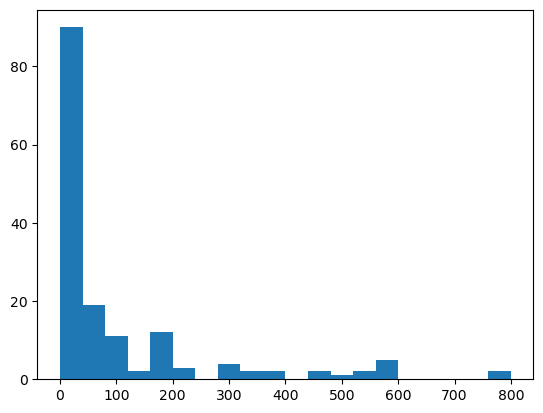

In [29]:
datacenters['power_capacity_mw'].describe()
plt.hist(datacenters['power_capacity_mw'], bins=20)

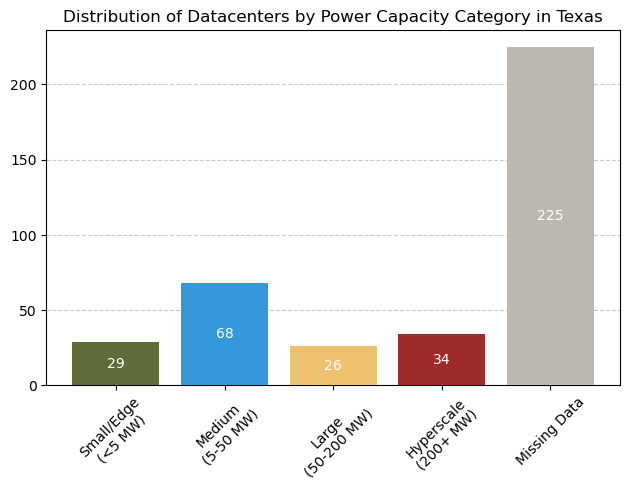

In [30]:
powercap_cat = datacenters['power_size_category'].value_counts()
order = ['Small/Edge (<5 MW)', 'Medium (5-50 MW)', 'Large (50-200 MW)', 'Hyperscale (200+ MW)', 'Missing Data']
labels = ['Small/Edge\n(<5 MW)', 'Medium\n(5-50 MW)', 'Large\n(50-200 MW)', 'Hyperscale\n(200+ MW)', 'Missing Data']
colors = ['#606c38', '#3498db', '#eec170', '#9e2a2b', '#bcb8b1']

ordered_values = [powercap_cat[cat] if cat in powercap_cat.index else 0 for cat in order]

plt.bar(labels, ordered_values, color=colors, zorder=3)
plt.bar_label(plt.gca().containers[0], label_type='center', color='white', fontsize=10)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)
plt.tight_layout()
plt.title('Distribution of Datacenters by Power Capacity Category in Texas')
plt.show()

(array([1.5749e+04, 1.5260e+03, 6.9200e+02, 5.1600e+02, 2.8500e+02,
        2.0000e+02, 1.6400e+02, 1.2000e+02, 3.2000e+01, 3.2000e+01,
        3.3000e+01, 2.2000e+01, 8.0000e+00, 8.0000e+00, 7.0000e+00,
        1.0000e+01, 6.0000e+00, 1.5000e+01, 1.7000e+01, 1.5000e+01]),
 array([ -17274. ,  182755.3,  382784.6,  582813.9,  782843.2,  982872.5,
        1182901.8, 1382931.1, 1582960.4, 1782989.7, 1983019. , 2183048.3,
        2383077.6, 2583106.9, 2783136.2, 2983165.5, 3183194.8, 3383224.1,
        3583253.4, 3783282.7, 3983312. ]),
 <BarContainer object of 20 artists>)

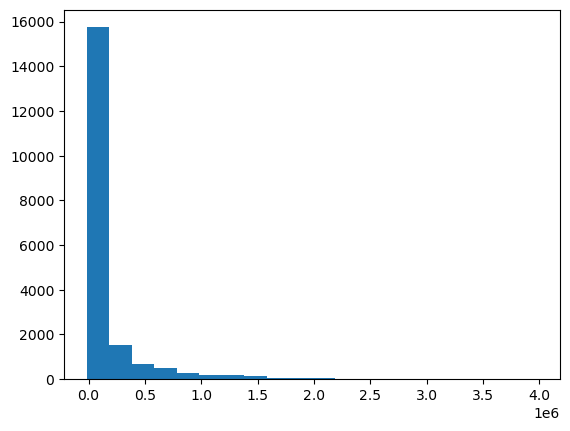

In [31]:
total_monthly_egen_by_fueltype['total_generation'].describe()
plt.hist(total_monthly_egen_by_fueltype['total_generation'], bins=20)

**Power Capacity**: Highly right-skewed distribution, representative of earlier bar plot that most facilities are small/medium (<50 MW), but hyperscale facilities (>200 MW) dominate total capacity.

**Total Generation**: Extremely right-skewed (most counties generate <500k MWh/month)

### III. Summary Statistics (Shape... Structure... Data Types....)

In [32]:
datacenter_agg_weather.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 382 entries, 0 to 381
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   datacenter                    382 non-null    object  
 1   operator                      382 non-null    object  
 2   address                       382 non-null    object  
 3   city                          382 non-null    object  
 4   postal_code                   382 non-null    object  
 5   county                        375 non-null    object  
 6   Solar Region                  375 non-null    object  
 7   Wind Region                   375 non-null    object  
 8   power_capacity_mw             157 non-null    float64 
 9   building_size_sqft            153 non-null    float64 
 10  whitespace_sqft               95 non-null     float64 
 11  whitespace_ratio              55 non-null     float64 
 12  geometry_x                    382 non-null

In [33]:
datacenter_agg_weather.describe()

,power_capacity_mw,building_size_sqft,whitespace_sqft,whitespace_ratio,latitude,longitude,wet_bulb_temperature_2m_mean,wet_bulb_temperature_2m_max,wet_bulb_temperature_2m_std,temperature_2m_mean,temperature_2m_max,precipitation_mean,precipitation_sum,relative_humidity_2m_mean
count,157.000000,1.530000e+02,9.500000e+01,55.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000
mean,105.214662,2.883839e+05,1.072790e+05,0.680820,31.524958,-97.426296,60.939541,83.711472,13.761098,69.636681,108.336678,0.005598,152.295502,64.413544
std,168.378474,4.709956e+05,1.997792e+05,0.575946,1.712292,1.822455,3.149624,2.153334,0.950886,2.057643,1.658055,0.001607,45.475723,6.777292
min,0.075000,1.500000e+03,1.500000e+03,0.084067,26.193490,-106.493388,49.251358,72.719528,10.182694,60.449760,98.474899,0.000778,21.035433,33.536457
25%,7.200000,5.000000e+04,2.500000e+04,0.386887,29.922817,-97.728497,59.522343,82.840637,12.868791,68.212553,107.024902,0.005031,136.090546,63.557842
50%,36.000000,1.300000e+05,4.850000e+04,0.533333,32.562113,-96.865574,60.267487,84.134571,14.391659,69.067360,108.640854,0.005993,162.102371,64.620430
75%,100.000000,3.500000e+05,1.030000e+05,0.861213,32.905120,-96.708717,62.616765,85.024410,14.545679,71.239330,109.369175,0.006468,174.937012,65.558405
max,800.000000,3.880000e+06,1.500000e+06,4.392000,35.485458,-95.037997,69.479065,87.015152,15.148311,76.681656,114.212296,0.008499,337.125977,78.462105


In [34]:
monthly_agg_county_fuel_mix.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5864 entries, 0 to 5863
Data columns (total 39 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   county                                5864 non-null   object  
 1   Solar Region                          5864 non-null   object  
 2   Wind Region                           5864 non-null   object  
 3   geometry                              5864 non-null   geometry
 4   period                                5793 non-null   object  
 5   Coal_gen_total                        5793 non-null   float64 
 6   Distillate Fuel Oil_gen_total         5793 non-null   float64 
 7   Hydroelectric Conventional_gen_total  5793 non-null   float64 
 8   Municiapl Landfill Gas_gen_total      5793 non-null   float64 
 9   Natural Gas_gen_total                 5793 non-null   float64 
 10  Nuclear_gen_total                     5793 non-null   float64 
 

In [35]:
monthly_agg_county_fuel_mix.describe()
county_fuel_null = monthly_agg_county_fuel_mix.isna().sum()
print(county_fuel_null)

county                                    0
Solar Region                              0
Wind Region                               0
geometry                                  0
period                                   71
Coal_gen_total                           71
Distillate Fuel Oil_gen_total            71
Hydroelectric Conventional_gen_total     71
Municiapl Landfill Gas_gen_total         71
Natural Gas_gen_total                    71
Nuclear_gen_total                        71
Other_gen_total                          71
Other Gases_gen_total                    71
Petroleum Coke_gen_total                 71
Residual Fuel Oil_gen_total              71
Solar_gen_total                          71
Waste Oil and Other Oils_gen_total       71
Wind_gen_total                           71
Wood Waste Solids_gen_total              71
other renewables_gen_total               71
total_generation                         71
Coal_gen_pct                            164
Distillate Fuel Oil_gen_pct     

In [36]:
dc_weather_null = datacenter_agg_weather.isna().sum()
print(dc_weather_null)

datacenter                        0
operator                          0
address                           0
city                              0
postal_code                       0
county                            7
Solar Region                      7
Wind Region                       7
power_capacity_mw               225
building_size_sqft              229
whitespace_sqft                 287
whitespace_ratio                327
geometry_x                        0
latitude                          0
longitude                         0
power_size_category               0
wet_bulb_temperature_2m_mean      0
wet_bulb_temperature_2m_max       0
wet_bulb_temperature_2m_std       0
temperature_2m_mean               0
temperature_2m_max                0
precipitation_mean                0
precipitation_sum                 0
relative_humidity_2m_mean         0
geometry_y                        0
dtype: int64


### IV. Distribution of Data

### IV. Testing for Normality: Q-Q PLot


Analyzing dataset: datacenter_agg_weather


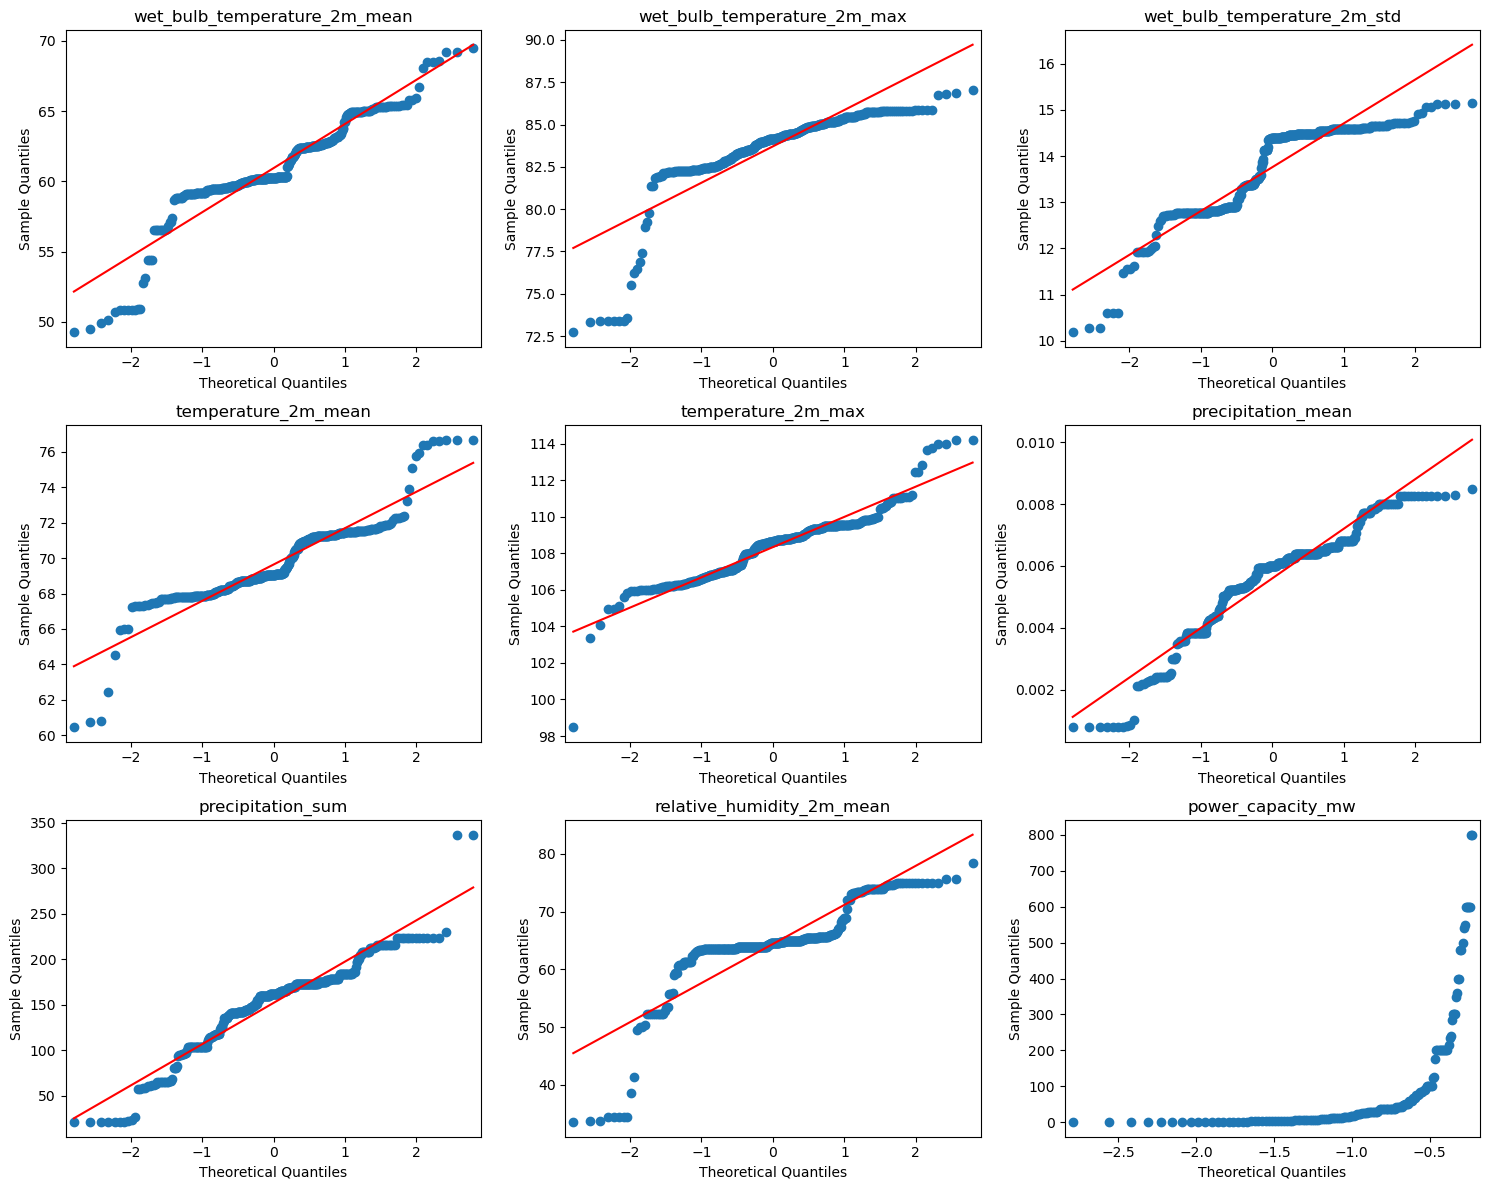


Analyzing dataset: county_fuel


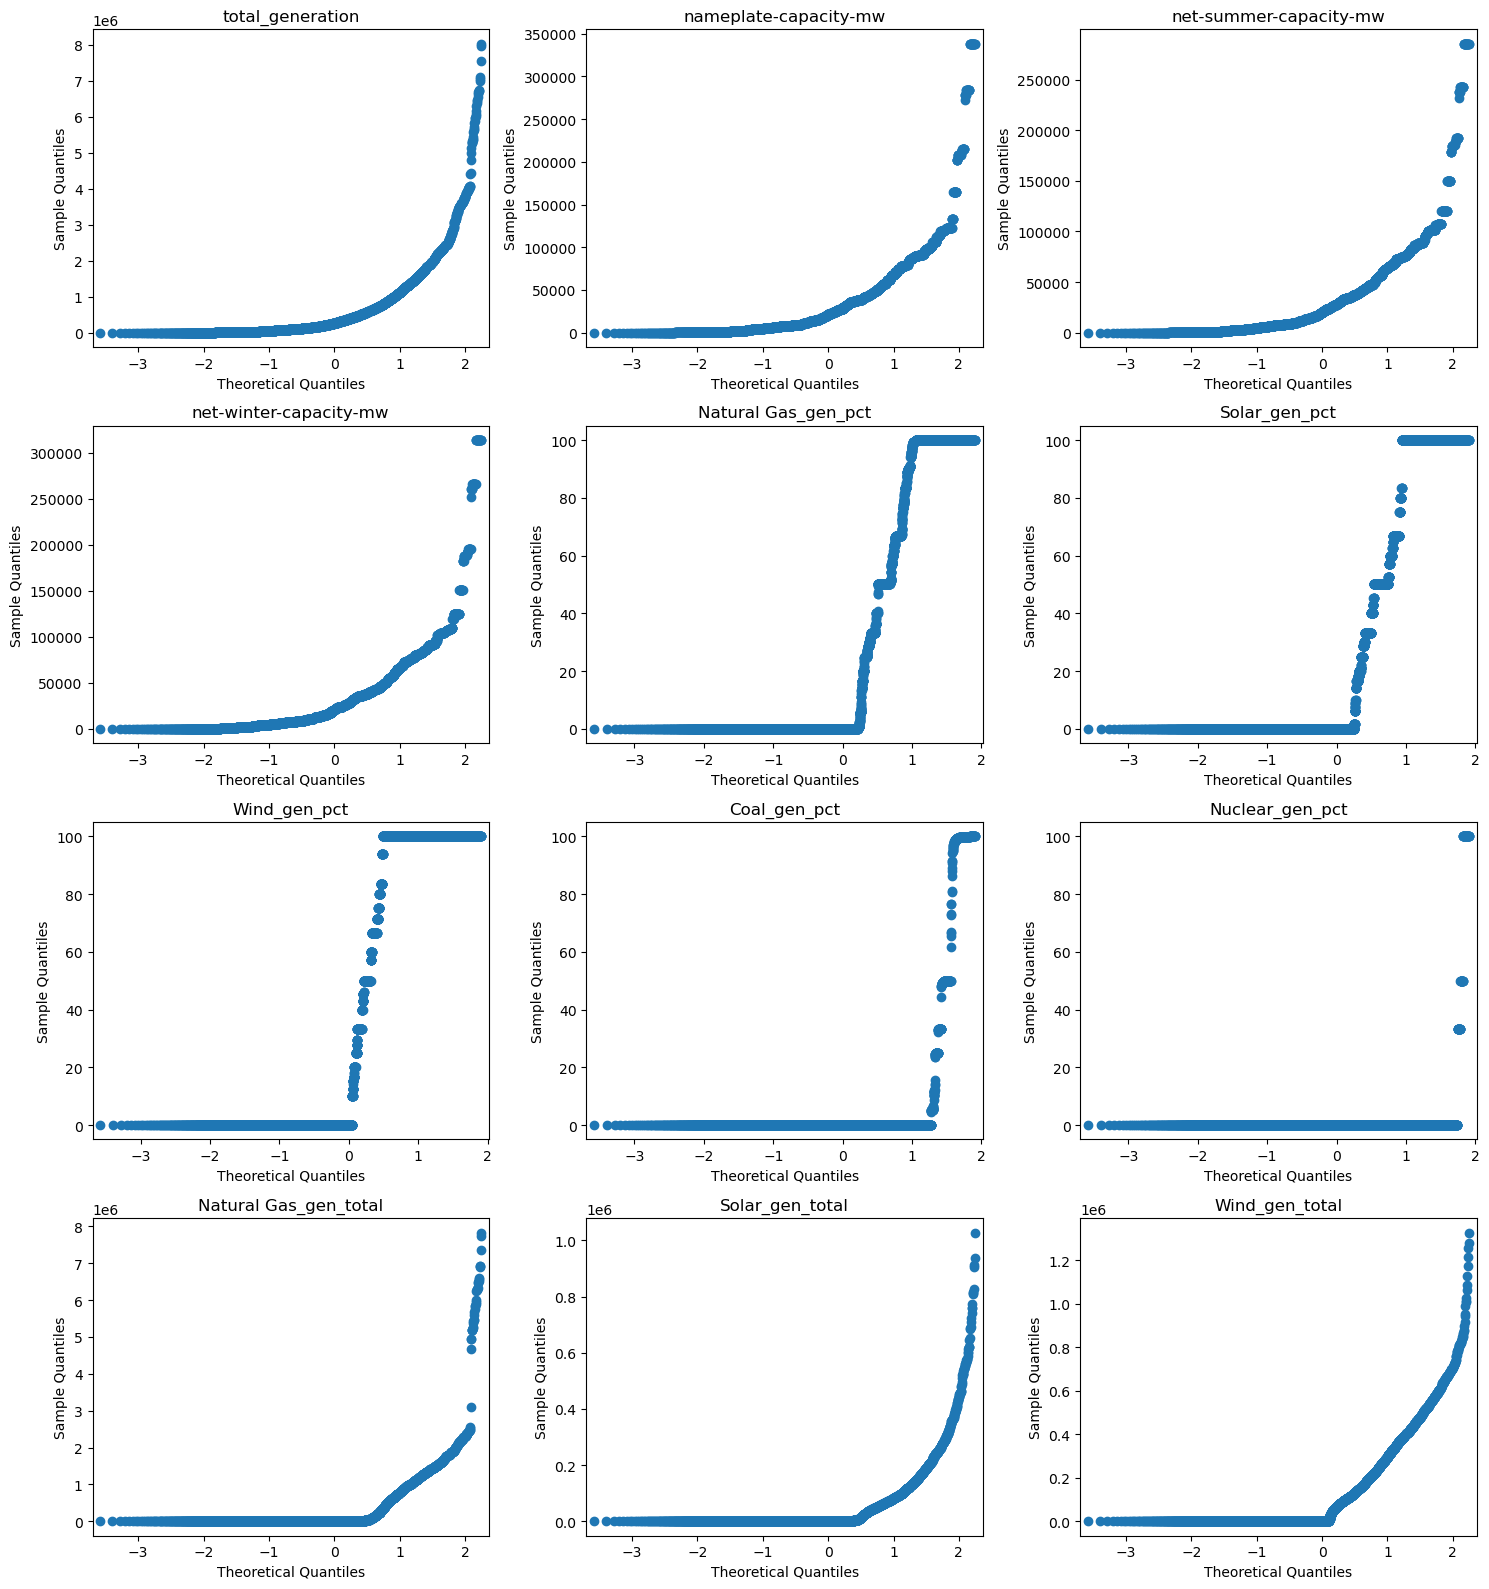

In [37]:
# Variables to test for normality
variables_to_test = {
    # Data Center Weather Variables
    'datacenter_agg_weather': [
        'wet_bulb_temperature_2m_mean',
        'wet_bulb_temperature_2m_max',
        'wet_bulb_temperature_2m_std',
        'temperature_2m_mean',
        'temperature_2m_max',
        'precipitation_mean',
        'precipitation_sum',
        'relative_humidity_2m_mean',
        'power_capacity_mw'],
    
    # County-Level Fuel Mix
    'county_fuel': [
        'total_generation', 'nameplate-capacity-mw', 'net-summer-capacity-mw', 'net-winter-capacity-mw',
        'Natural Gas_gen_pct',
        'Solar_gen_pct',
        'Wind_gen_pct',
        'Coal_gen_pct',
        'Nuclear_gen_pct',
        'Natural Gas_gen_total',
        'Solar_gen_total',
        'Wind_gen_total']}
df = {'datacenter_agg_weather': datacenter_agg_weather, 'county_fuel': monthly_agg_county_fuel_mix}

for dataset_name, variables in variables_to_test.items():
    current_df = df[dataset_name]
    n_vars = len(variables)
    n_cols = 3  # number of plots per row
    n_rows = -(-n_vars // n_cols) # ceiling division
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten()  # flatten in case of multiple rows
    
    print(f"\nAnalyzing dataset: {dataset_name}")
    
    for i, var in enumerate(variables):
        sm.qqplot(current_df[var], line='s', ax=axes[i])
        axes[i].set_title(var)
    
    # Remove any empty subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

#### Q-Q Plot Results Summary

- The `wet_bulb` variables all exhibit a step pattern that needs to be normalized before incorporating into modeling.  
- Both `power_capacity_mw` and `total_generation` appear highly skewed and need log transformation.
- The fuel_mix_pct variables and particular weather variables, such as `precipitation_sum`, also appeared slightly/moderately skewed and could perhaps use square root transformation or other methods. 

#### Transformations

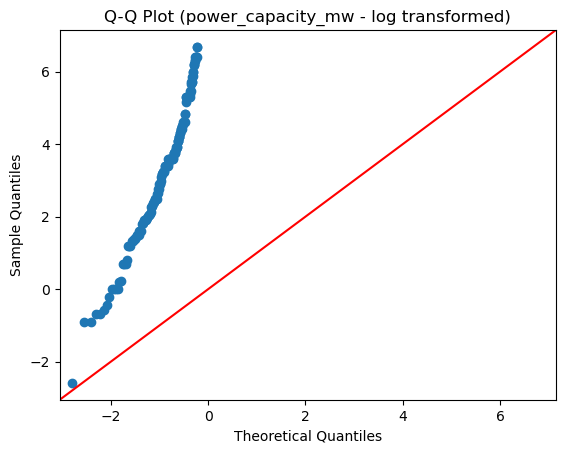

In [40]:
datacenter_agg_weather['dc_capacity_log'] = np.log(datacenter_agg_weather['power_capacity_mw'])  # log-transform with offset to avoid log(0)

sm.qqplot(datacenter_agg_weather["dc_capacity_log"], line='45') # setup for the QQ plot selecting the data column and 45 degree line
plt.title("Q-Q Plot (power_capacity_mw - log transformed)") # add title to the plot
plt.show()

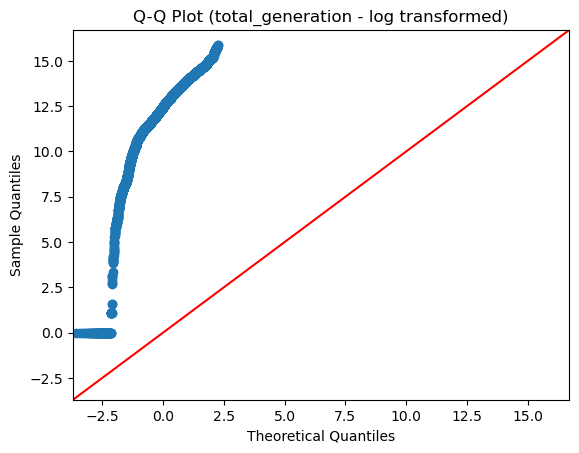

In [39]:
monthly_agg_county_fuel_mix['total_generation_log'] = np.log(monthly_agg_county_fuel_mix['total_generation'] + 1)  # log-transform with offset to avoid log(0)
sm.qqplot(monthly_agg_county_fuel_mix["total_generation_log"], line='45') # setup for the QQ plot selecting the data column and 45 degree line
plt.title("Q-Q Plot (total_generation - log transformed)") # add title to the plot
plt.show()

### V. Testing for Potential Relationships: Correlation Matrices

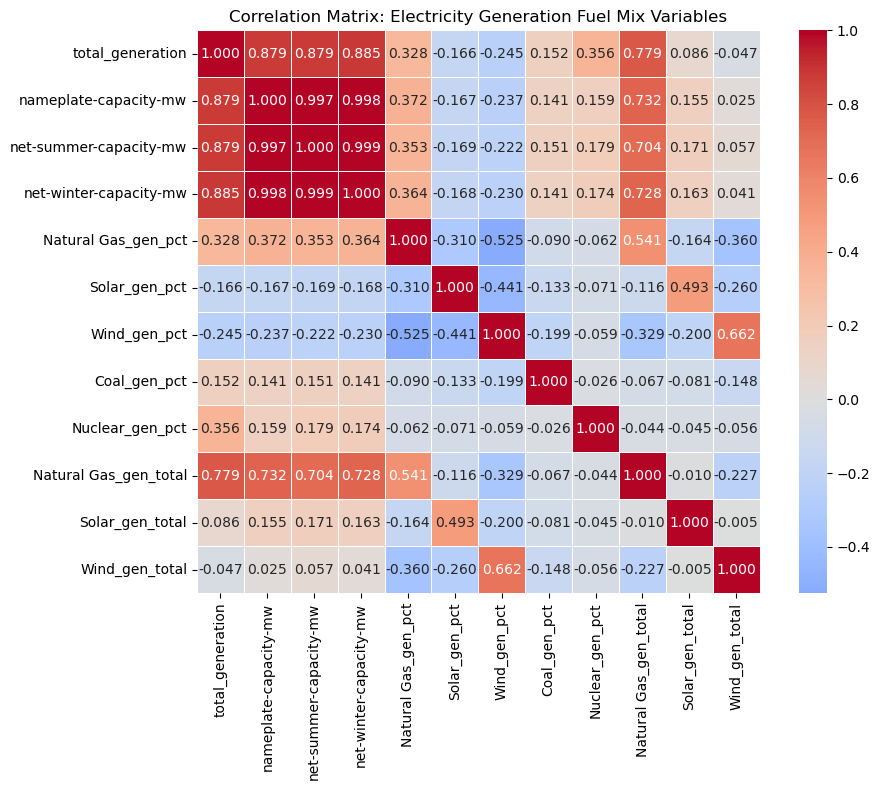

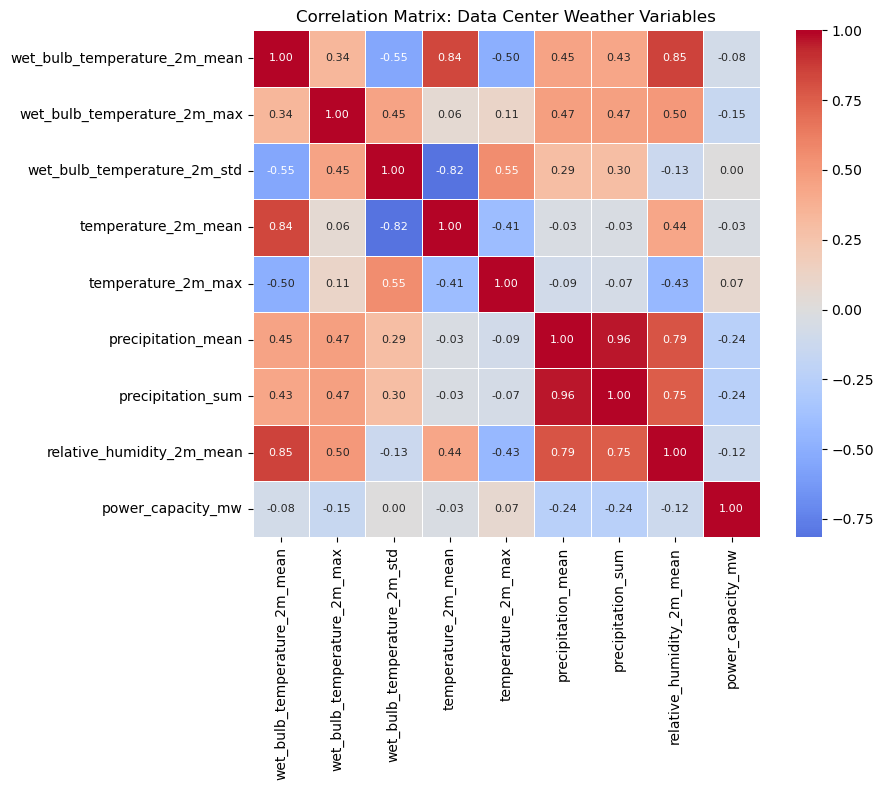

In [41]:
# Create correlation matrix for monthly_agg_county_fuel_mix variables
fuel_corr = monthly_agg_county_fuel_mix[[
    'total_generation', 
    'nameplate-capacity-mw', 
    'net-summer-capacity-mw', 
    'net-winter-capacity-mw',
    'Natural Gas_gen_pct',
    'Solar_gen_pct',
    'Wind_gen_pct',
    'Coal_gen_pct',
    'Nuclear_gen_pct',
    'Natural Gas_gen_total',
    'Solar_gen_total',
    'Wind_gen_total']].corr()

# Create a heatmap visualization
plt.figure(figsize=(10, 8))
sns.heatmap(fuel_corr, 
            annot=True,           # Show correlation values
            cmap='coolwarm',      # Color scheme
            center=0,             # Center colormap at 0
            square=True,          # Square cells
            linewidths=0.5,       # Lines between cells
            fmt='.3f')            # 3 decimal places

plt.title('Correlation Matrix: Electricity Generation Fuel Mix Variables')
plt.tight_layout()
plt.show()

# Create correlation matrix for datacenter_agg_weather variables
weather_corr = datacenter_agg_weather[[
    'wet_bulb_temperature_2m_mean',
    'wet_bulb_temperature_2m_max',
    'wet_bulb_temperature_2m_std',
    'temperature_2m_mean',
    'temperature_2m_max',
    'precipitation_mean',
    'precipitation_sum',
    'relative_humidity_2m_mean',
    'power_capacity_mw'
]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(weather_corr, 
            annot=True,
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=0.5,
            fmt='.2f',
            annot_kws={'size': 8})
plt.title('Correlation Matrix: Data Center Weather Variables')
plt.tight_layout()
plt.show()
